# NP

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
from dataloading_helpers import electricity_dataloader
from config import *

In [9]:
set_log_level("ERROR")
set_random_seed(111)

## 1. Electricity dataset

In [5]:
train, test, val = electricity_dataloader.create_electricity_timeseries_np()

train["date"] =  pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S.%f')
test["date"] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S.%f')
val["date"] =  pd.to_datetime(val['date'], format='%Y-%m-%d %H:%M:%S.%f')

train.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)
test.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)
val.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)


# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 


#data = df[input_columns]                                      # only minimal set                 
train_data = train[input_columns + lagged_regressors]          # with regressors
test_data = test[input_columns + lagged_regressors] 
val_data = val[input_columns + lagged_regressors] 

In [26]:
# prepare data to required format
def prepare_data(df):
    ''' A dataset with NeuralProphet must be a pandas dataframe with:
            1.Time series column must be named "ds" and contain a datetime object without timezone information.
            2.Value column must be named "y" and contain a float value.
    '''
    df.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)
    
    #df['ID'] = df['ID'].astype('string').astype('category')        # do not convert if you want to use only part of data in m.split_df
    print(df.info())
    return df

df = prepare_data(df)     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198072 entries, 17544 to 10461486
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   y                        float64       
 1   t                        float64       
 2   days_from_start          int64         
 3   categorical_id           object        
 4   ds                       datetime64[ns]
 5   ID                       object        
 6   hour                     int64         
 7   day                      int64         
 8   day_of_week              int64         
 9   month                    int64         
 10  hours_from_start         float64       
 11  categorical_day_of_week  int64         
 12  categorical_hour         int64         
dtypes: datetime64[ns](1), float64(3), int64(7), object(2)
memory usage: 234.8+ MB
None


## Model

In [29]:
# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 

In [30]:
# specify data for input:

#data = df[input_columns]                             # only minimal set                 
data = df[input_columns + lagged_regressors]          # with regressors

In [13]:
def get_model():
    m = NeuralProphet(
        growth = "off",                    # no trend
        trend_global_local = "global",
        season_global_local = "global",                
        n_lags = 7*24,                      # autoregressor on last 24h x 7 days
        n_forecasts = 24,                   # forecast horizon
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        learning_rate = 0.1,
        loss_func = "MSE",
        #epochs=3,                         # will be specified further
        #trainer_config = {"accelerator":"gpu"},
        #num_hidden_layers=1,
        #d_hidden=16
        quantiles = [0.1, 0.5, 0.9],
        normalize= "off",
        global_normalization=False
    )
    
    m = m.highlight_nth_step_ahead_of_each_forecast(step_number = m.n_forecasts)
    
    m = m.add_lagged_regressor(names = lagged_regressors, normalize = False)   # , only_last_value=True)
    
    return m

In [14]:
m = get_model()

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (168)


In [38]:
def split_train_test(df, model, num_id=0, valid_p=0.3):
    '''
    to ran only on part of data (for first # id) :   specify parameter num_id, e.g. num_id=5 (for first 5 ids)
    '''
    if num_id==0:
        df = df
    else:
        df = df[df.ID.isin(df.ID.unique()[:num_id])]
    
    df_train, df_test = model.split_df( 
        df,    
        freq='H',
        valid_p = valid_p,         
        local_split = True
    )
    
    return df_train, df_test

df_train, df_test = split_train_test(data, m, 3)

In [39]:
# check
df_train.ID.value_counts()

MT_001    4242
MT_002    4242
MT_003    4242
Name: ID, dtype: int64

In [15]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

def fit_model(m, df_train, df_val, num_epochs, batch_size, learning_rate, num_workers):
    start_time = time.perf_counter()

    metrics = m.fit(
        df = df_train, 
        validation_df = df_val,
        freq='H', 
        progress="plot",
        num_workers = num_workers,
        #early_stopping=True,
        learning_rate=learning_rate,
        epochs=num_epochs,
        batch_size=batch_size
    )                                            
    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f'Training Took {total_time:.4f} seconds')
    
    return metrics   


metrics = fit_model(m, 
                    df_train=train_data, 
                    df_val=val_data, 
                    num_epochs=5, 
                    batch_size=128, 
                    learning_rate=0.1, 
                    num_workers=14
                   )

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined 

Training: 0it [00:00, ?it/s]

KeyError: "None of [Index(['Loss', 'Loss_val'], dtype='object')] are in the [columns]"

In [ ]:
import pickle


with open('models/electricity/neuralprophet_model.pkl', "wb") as f:
    # dump information to that file
    pickle.dump(metrics, f)

In [ ]:
metrics

In [42]:
# evaluate the test metrics considering time series from all id
m.test(df_test)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.17793993651866913    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.17794,0.0


In [44]:
# create a future data frame consisting of the time steps into the future that we need to forecast
future = m.make_future_dataframe(
    df_test,                          
    n_historic_predictions = True
)

In [ ]:
forecast = m.predict(future)

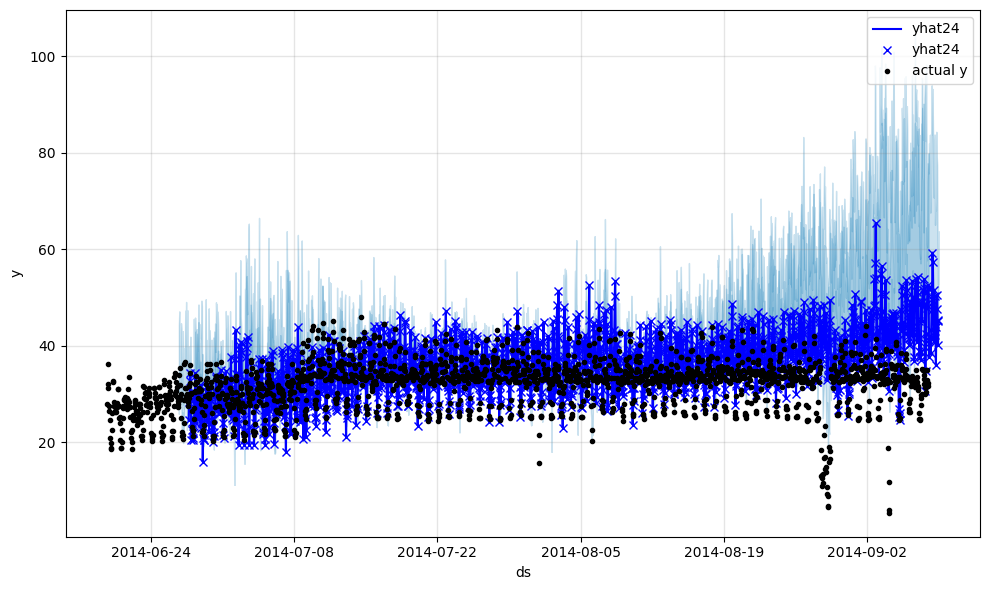

In [71]:
fig = m.plot(forecast[forecast["ID"] == "MT_002"])

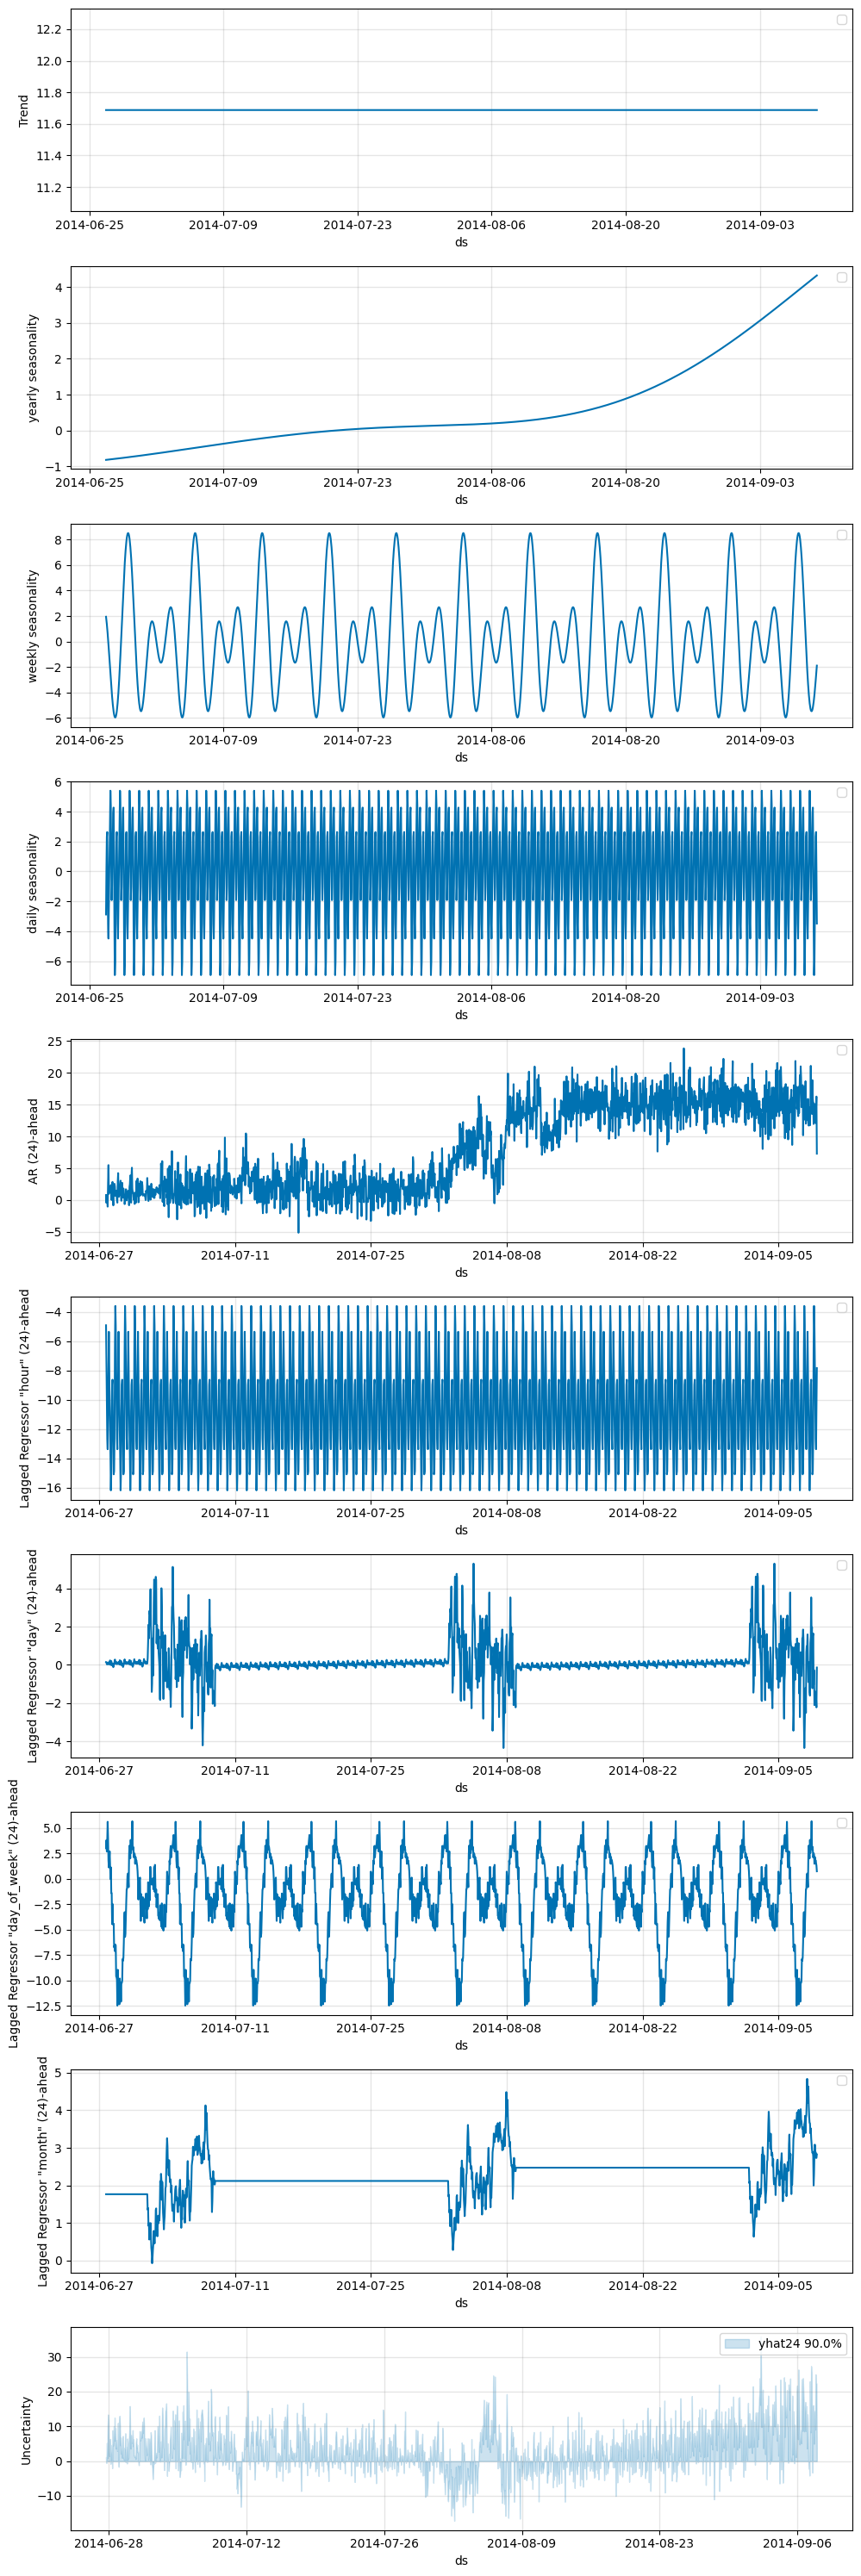

In [65]:
fig = m.plot_components(forecast[forecast["ID"] == 'MT_001'])

#fig = m.plot_components(forecast[-8 * 24 :])   #print only for last 7 days